**Author:** **Ritesh** **Chowdhry**
## **Description**: 
In this notebook I have created a CNN Model for training Fashion_MNIST dataset. The dataset has been imported from datasets module in torchvision pytorch.  
 
### Second cell:
*   In the second cell I have written all the utility functions, model and training function. 
*   The training function also has the code for plotting loss and accuracy plots and early stopping (which requires validation == True in training function so, validation set is required for that).

### Last cell:
It has to code for testing the model on test dataset and plot confusion matrix.


---


### To do:


1.   Experiment and prepare a literature of comparison in model performance for different hyperparamters.
>> Optimizer (SGD and Adam)  
>> Loss function (Cross entropy and MSE)  
>> Learning rate 




2. Include validation for early stopping and prepare evidence that it stops at the right step.  




 
  


In [1]:
#Importing the libraries

import pandas as pd
import numpy as np
import shutil

# Pytorch modules used in my code.

import torch

from torch import nn
from torch.utils.data import DataLoader



from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Conv2d

from torchvision import transforms
from torchvision import datasets

# These modules are which I've used for results visulaization.
from sklearn.metrics import confusion_matrix, classification_report, multilabel_confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import time

# This is just for interfacing the training progress.
from tqdm.autonotebook import tqdm
from google.colab import files
try:
  import wandb
except:
  # WandB – Install the W&B library
  !pip install wandb -q
  import wandb


#Source: https://github.com/Bjarten/early-stopping-pytorch/blob/master/MNIST_Early_Stopping_example.ipynb
try:
  shutil.move("/content/early-stopping-pytorch/pytorchtools.py","/content/pytorchtools.py")
  from pytorchtools import EarlyStopping
except:
  !git clone https://github.com/Bjarten/early-stopping-pytorch.git
  shutil.move("/content/early-stopping-pytorch/pytorchtools.py","/content/pytorchtools.py")
  from pytorchtools import EarlyStopping

     |████████████████████████████████| 1.7MB 4.7MB/s 
     |████████████████████████████████| 163kB 29.5MB/s 
     |████████████████████████████████| 122kB 30.2MB/s 
     |████████████████████████████████| 102kB 11.6MB/s 
     |████████████████████████████████| 102kB 11.3MB/s 
     |████████████████████████████████| 71kB 6.4MB/s 
Cloning into 'early-stopping-pytorch'...
remote: Enumerating objects: 92, done.
remote: Total 92 (delta 0), reused 0 (delta 0), pack-reused 92
Unpacking objects: 100% (92/92), done.


In [2]:
# This cell has all the utility functions, model and training function.

# CNN_model used in this notebook.
class network(nn.Module):
  def __init__(self,dropout_flag,layers):
    super(network, self).__init__()
    self.layer1 = nn.Sequential(nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2))
    if(layers>1):
      self.layer2 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),nn.ReLU(),nn.MaxPool2d(kernel_size=2, stride=2))
    if(dropout_flag == True):
      self.drop_out = nn.Dropout(p=0.6)
    if(layers>1):
      self.fc1 = nn.Linear(7 * 7 * 64, 1000)
    else:
      self.fc1 = nn.Linear(14 * 14 * 32, 1000)
    self.fc2 = nn.Linear(1000, 10)
  def forward(self, x):
    x = self.layer1(x)
    if(layers>1):
      x = self.layer2(x)
    x = x.reshape(x.size(0), -1)
    if(dropout_flag == True):
      x = self.drop_out(x)
    x = self.fc1(x)
    x = self.fc2(x)
    return x

# Train the model
def training(train_dataloader, model, learning_rate, num_epochs, patience_for_early_stopping, start_time = 0.0,loss_function = "Cross Entropy",optimizer_choice = "SGD",name_run_wandb = "random_run",
             wandb_log_status = True, validation = False, validation_loader = None, plots = False):

  log_train_loss = []
  log_train_accuracy = []
  log_valid_loss = []
  log_valid_accuracy = []
  epoch_plot_values = []
  if torch.cuda.is_available():
    device_available = torch.device("cuda")  
  else: 
      device_available = torch.device("cpu")
  print(device_available)

  # initialize the early_stopping object
  if(validation == True):
    early_stopping = EarlyStopping(patience=patience_for_early_stopping, verbose=True)

  onehot_encoder = OneHotEncoder(sparse=False)
  # Loss and optimizer
  if(loss_function == "Cross Entropy"):
    criterion = nn.CrossEntropyLoss()
  elif(loss_function == "MSE"):
    criterion = nn.MSELoss()
  
  if(optimizer_choice == "SGD"):
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=learning_rate/4)
  elif(optimizer_choice == "adam"):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  
  model.train()

  if(wandb_log_status == True):
    wandb.watch(model, log="all")
    

  for epoch in range(num_epochs):
    train_mean_loss = 0
    train_mean_acc = 0
    rand_var = 0

    temp_print = 0
    
    for i, (train_images, train_label) in enumerate(train_dataloader):
      """
      rand_var += 1
      if(rand_var == 10):
        break
      """
      # Run the forward pass
      train_images = train_images.to(device_available)
      train_label = train_label.to(device_available)
      train_output = model(train_images)
      loss = criterion(train_output, train_label)
      train_mean_loss +=loss.item()

      train_acc = calc_accuracy(train_output,train_label)
      train_mean_acc += train_acc 
      temp_print += 1
      # if(temp_print%20==0):
      #   print("Accuracy for batch: ", train_acc)
      
      # Backprop and perform Adam optimisation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if(validation == True):
        with torch.no_grad():
          valid_mean_loss = 0
          valid_mean_acc = 0
          for valid_input,valid_label in validation_loader:
            valid_input = valid_input.to(device_available)
            valid_label = valid_label.to(device_available)
            valid_output = model(valid_input)
            valid_loss = criterion(valid_output,valid_label)
            valid_acc = calc_accuracy(valid_output,valid_label)
            valid_mean_acc += valid_acc
            valid_mean_loss += valid_loss.item() 

    log_train_loss.append((train_mean_loss/len(train_dataloader)))
    log_train_accuracy.append((train_mean_acc/len(train_dataloader)))
    if(validation == True):
      log_valid_loss.append((valid_mean_loss/len(validation_loader)))
      log_valid_accuracy.append((valid_mean_acc/len(validation_loader)))

    epoch_plot_values.append(epoch)
    
    print("Epoch:",epoch)
    print("Training Loss:",(train_mean_loss/len(train_dataloader)))
    print("Training accuracy:", (train_mean_acc/len(train_dataloader)), "%")
    if(wandb_log_status == True):
      wandb.log({"Train Accuracy": (train_mean_acc/len(train_dataloader)), "Train Loss": (train_mean_loss/len(train_dataloader))})

    if(validation == True):
      print("Validation loss:", valid_mean_loss/len(validation_loader))
      print("Valdation Accuracy:", valid_mean_acc/len(validation_loader),"%")
      if(wandb_log_status == True):
        wandb.log({"Valid Accuracy": (valid_mean_acc/len(validation_loader)), "Valid Loss": (valid_mean_loss/len(validation_loader))})

    print("*******************************************************")


    ############################ Early_stopping_condtion ############
    if(validation == True): 
      early_stopping((valid_mean_loss/len(validation_loader)), model)
        
      if early_stopping.early_stop:
          print("Early stopping")
          num_epochs = epoch
          break

      # if((valid_mean_acc/len(validation_loader)) == 100):
      #   print("Validation accuracy reached 100%, stopping early.")
      #   break
      # elif(len(log_valid_loss)>20):
      #   if(log_valid_loss[-20]<(sum(log_valid_loss[-20:])/20)):
      #     print(sum(log_valid_loss[-20:])/20)
      #     print("Validation loss started to increase, stopping early.")
      #     break

  if(plots == True):

    end_time = time.time()
    plot_x_limit = num_epochs - (1+num_epochs/10)
    # plot_x_limit = num_epochs 
    learning_rate_str = "Learning rate: " + str(learning_rate)
    loss_str = "Loss: " + str(loss_function)
    optimizer_str = "Optimizer: " + str(optimizer_choice)
    time_elapsed = "Training Time: "+str(round((end_time - start_time)/60,2)) + " min"

    ax1, ax2 = plot_function(epoch_plot_values,log_train_accuracy, log_train_loss, log_valid_loss, log_valid_accuracy, plot_x_limit, learning_rate_str, loss_str, optimizer_str, time_elapsed, validation)
    plt.show()

    train_loss_plot_name_run = "loss_plot"+ name_run_wandb + ".png"
    train_accuracy_plot_name_run = "accu_plot" + name_run_wandb + ".png"
    ax1.figure.savefig(train_loss_plot_name_run)
    ax2.figure.savefig(train_accuracy_plot_name_run)
    files.download(train_loss_plot_name_run)
    files.download(train_accuracy_plot_name_run)
    
def plot_function(epoch_plot_values,log_train_accuracy, log_train_loss, log_valid_loss, log_valid_accuracy, plot_x_limit, 
                  learning_rate_str, loss_str, optimizer_str, time_elapsed, validation):

  f1 = plt.figure(1)
  ax1 = f1.add_subplot(111)

  accuracy_graph_scale = (max(log_train_accuracy) - min(log_train_accuracy))/10
  y_for_accuracy_graph = min(log_train_accuracy)

  loss_graph_scale = (max(log_train_loss) - min(log_train_loss))/10
  y_for_loss_graph = min(log_train_loss)
  
  f2 = plt.figure(2)
  ax2 = f2.add_subplot(111)

  ax1.plot(epoch_plot_values,log_train_loss, '-b', label = 'Train loss')
  if(validation == True):
    ax1.plot(epoch_plot_values,log_valid_loss, '-r', label = 'Validation loss')
    ax1_title = "Train and Validation losses"
    ax1.set_title(ax1_title)
  else:
    ax1_title = "Train loss"
    ax1.set_title(ax1_title)
  ax1.set_xlabel("Epochs")
  ax1.set_ylabel("Loss")
  ax1.text(plot_x_limit,y_for_loss_graph + 2 * loss_graph_scale, learning_rate_str, ha="center", fontsize=10, bbox={"facecolor":"white", "alpha":0.5, "pad":5})
  ax1.text(plot_x_limit,y_for_loss_graph + 3 * loss_graph_scale, loss_str, ha="center", fontsize=10, bbox={"facecolor":"white", "alpha":0.5, "pad":5})
  ax1.text(plot_x_limit,y_for_loss_graph + 4 * loss_graph_scale, optimizer_str, ha="center", fontsize=10, bbox={"facecolor":"white", "alpha":0.5, "pad":5})
  ax1.text(plot_x_limit,y_for_loss_graph + 5 * loss_graph_scale, time_elapsed, ha="center", fontsize=10, bbox={"facecolor":"white", "alpha":0.5, "pad":5})
  ax1.legend()


  ax2.plot(epoch_plot_values,log_train_accuracy, '-b', label = 'Train Accuracy')


  if(validation == True):
    ax2.plot(epoch_plot_values,log_valid_accuracy, '-r', label = 'Validation Accuracy')
    ax2_title = "Train and Validation accuracy"
    ax2.set_title(ax2_title)
  else:
    ax2_title = "Train accuracy"
    ax2.set_title(ax2_title)

  ax2.set_xlabel("Epochs")
  ax2.set_ylabel("Accuracy")

  ax2.text(plot_x_limit,y_for_accuracy_graph, learning_rate_str, ha="center", fontsize=10, bbox={"facecolor":"white", "alpha":0.5, "pad":5})
  ax2.text(plot_x_limit,y_for_accuracy_graph + accuracy_graph_scale, loss_str, ha="center", fontsize=10, bbox={"facecolor":"white", "alpha":0.5, "pad":5})
  ax2.text(plot_x_limit,y_for_accuracy_graph + 2 * accuracy_graph_scale, optimizer_str, ha="center", fontsize=10, bbox={"facecolor":"white", "alpha":0.5, "pad":5})
  ax2.text(plot_x_limit,y_for_accuracy_graph + 3 * accuracy_graph_scale, time_elapsed, ha="center", fontsize=10, bbox={"facecolor":"white", "alpha":0.5, "pad":5})
  ax2.legend()
  return ax1, ax2


def calc_accuracy(prediction_tensor, true_val_tensor):
  # This function is just to calculate the accuracy given the prediction and the true value of a batch of data.
  prediction_tensor = torch.log_softmax(prediction_tensor, dim = 1)
  _, max_idx = torch.max(prediction_tensor, dim = 1)

  true_val = true_val_tensor.tolist()
  predicted_val = max_idx.cpu().numpy()

  correct_count = 0
  for i in range(len(true_val)):
      
      if(predicted_val[i]==true_val[i]):
          correct_count += 1

  accuracy = (correct_count / len(true_val))*100 
  return accuracy
  


def confusion_matrix_plot(c_matrix, classes, title = "Confusion Matrix", bg_color = "silver", name_run_wandb = "random_run"):
  # This function if for plotting the confusion matrix.
      
  c_map=plt.cm.Greys
  plt.imshow(c_matrix, interpolation='nearest', cmap=c_map)

  plt.gcf().set_facecolor(bg_color)
  plt.title(title)

  axes = np.arange(len(classes))

  plt.xticks(axes, classes, rotation=45)
  plt.yticks(axes, classes)

  plt.ylabel(' True Image Label')
  plt.xlabel('\n Predicted Label')

  thresh = c_matrix.max() / 2.

  for i in range((c_matrix.shape[0])):
      for j in range((c_matrix.shape[1])):
          if c_matrix[i, j] > thresh:
              text_color = "white"  
          else:
              text_color = "black"
          plt.text(j, i, c_matrix[i, j], horizontalalignment="center", color = text_color)
  
  CM_name_run = "CM_"+ name_run_wandb + ".png"
  plt.savefig(CM_name_run, bbox_inches="tight")
  files.download(CM_name_run)
  plt.show()

def prediction(test_dataloader, model,wandb_log_status = True):
  # This function is for predicting with help of the trained model.
  correct_label = []
  if torch.cuda.is_available():
    device_available = torch.device("cuda")  
  else: 
      device_available = torch.device("cpu")
  print(device_available)
  prediction_dataset = []
  with torch.no_grad():
    model.eval()
    test_accuracy = 0
    for i,(test_input,label) in enumerate(test_dataloader):
      test_input = test_input.to(device_available)
      label = label.to(device_available)
      output = model(test_input)
      accuracy = calc_accuracy(output,label)
      test_accuracy += accuracy
      output = torch.log_softmax(output, dim = 1)
      _, max_idx = torch.max(output, dim = 1)
      prediction_dataset.append(max_idx.cpu().numpy())
      correct_label.append(label.tolist())
          
  prediction_dataset = [pred.squeeze().tolist() for pred in prediction_dataset]
  # print(prediction_dataset)
  # print(correct_label)
  print("Accuracy: ",  (test_accuracy/len(test_dataloader)))
  if(wandb_log_status == True):
      wandb.log({"Test Accuracy": (test_accuracy/len(test_dataloader))})
  return prediction_dataset, correct_label, (test_accuracy/len(test_dataloader))

In [3]:
# transforms to apply to the data
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

path_data = "/content"
validation_status = True

# FashionMNIST dataset
train_dataset = datasets.FashionMNIST(root=path_data, train=True, transform=trans, download=True)
test_dataset = datasets.FashionMNIST(root=path_data, train=False, transform=trans, download=True)

if(validation_status == True):
  train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000])
  # train_dataset, val_dataset= train_test_split(train_dataset, test_size=0.1, stratify = train_dataset)


Extracting /content/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/FashionMNIST/raw



Extracting /content/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/FashionMNIST/raw


Extracting /content/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/FashionMNIST/raw


Extracting /content/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
model_train_iteration = 0
dropout_flag = False
layers = 2

if torch.cuda.is_available():
    device_available = torch.device("cuda")  
else: 
    device_available = torch.device("cpu")
print(device_available)

model = network(dropout_flag,layers)
# Changing device to GPU if available.
model = model.to(device_available)


train_batch_size = 100
valid_batch_size = 50
test_batch_size = 50


# train_dataset = my_dataset_class(train_set_name)
train_loader = DataLoader(dataset=train_dataset, batch_size = train_batch_size, shuffle=True)
print("Train Loader", len(train_loader))

if(validation_status == True):
  val_loader = DataLoader(dataset=val_dataset, batch_size = valid_batch_size, shuffle=True)
  print("Valid Loader", len(val_loader))

# test_dataset = my_dataset_class("test.csv")
test_loader = DataLoader(dataset=test_dataset, batch_size = test_batch_size, shuffle=False)
print("Test Loader", len(test_loader))

cuda


Train Loader 500
Valid Loader 200
Test Loader 200


In [5]:
#make sure data is balanced 
Dictionary_counts = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}
total = 0
for _,train_label in train_loader:
  for i in train_label:
      digit = int(i.numpy())
      Dictionary_counts[digit] +=1
      total +=1
# for key in range(10):
#     Dictionary_counts[key] = Dictionary_counts[key]/total
print(Dictionary_counts)

{0: 4956, 1: 4977, 2: 5002, 3: 4975, 4: 5029, 5: 5048, 6: 5045, 7: 4985, 8: 4952, 9: 5031}


In [6]:
# Hyperparameters
num_epochs = 30
num_classes = 10
batch_size = 100
learning_rate = 0.0001
patience_value = 6
path_model_final_save = "/content/"

if(dropout_flag == True):
  dropout_str = "drop0.6_"
else:
  dropout_str = ""

layers_str = str(layers)+"_layer_"

loss_function_param = "Cross Entropy"
optimizer_choice_param = "adam"

if(loss_function_param == "Cross Entropy"):
  wandb_loss_str = "CE" + "_"
else: 
  wandb_loss_str = str(loss_function_param) + "_"

wandb_optimizer_str = str(optimizer_choice_param) + "_"
wandb_learning_rate_str = str(learning_rate)
# wandb_epoch = "_ep:" + str(num_epochs)

wandb_run_name = layers_str + dropout_str + wandb_loss_str + wandb_optimizer_str + wandb_learning_rate_str 
print("Name according to config:",wandb_run_name)



wandb_run_name = "Adam_final"

print("Updated name: ",wandb_run_name)


Name according to config: 2_layer_CE_adam_0.0001
Updated name:  Adam_final


In [7]:
flag_wandb_log_status = True
# WandB – Login to your wandb account so you can log all your metrics
if(flag_wandb_log_status == True):
  !wandb login f2f1f4df7b1e6956f86b9a5ae53189dbf6704280
  #API Key: f2f1f4df7b1e6956f86b9a5ae53189dbf6704280
  run_object = wandb.init(name = wandb_run_name,project="project_nn_dl")


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: Currently logged in as: riteshchowdhry (use `wandb login --relogin` to force relogin)


cuda
Epoch: 0
Training Loss: 0.5956880419850349
Training accuracy: 79.028 %
Validation loss: 0.4219557123631239
Valdation Accuracy: 85.49 %
*******************************************************
Validation loss decreased (inf --> 0.421956).  Saving model ...
Epoch: 1
Training Loss: 0.3844985328614712
Training accuracy: 86.426 %
Validation loss: 0.3565004539489746
Valdation Accuracy: 87.3 %
*******************************************************
Validation loss decreased (0.421956 --> 0.356500).  Saving model ...
Epoch: 2
Training Loss: 0.3326712548136711
Training accuracy: 88.18 %
Validation loss: 0.3234728676453233
Valdation Accuracy: 88.4 %
*******************************************************
Validation loss decreased (0.356500 --> 0.323473).  Saving model ...
Epoch: 3
Training Loss: 0.30190714985132217
Training accuracy: 89.11 %
Validation loss: 0.3027938756719232
Valdation Accuracy: 89.36 %
*******************************************************
Validation loss decreased (0.323

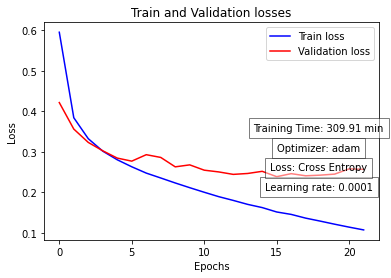

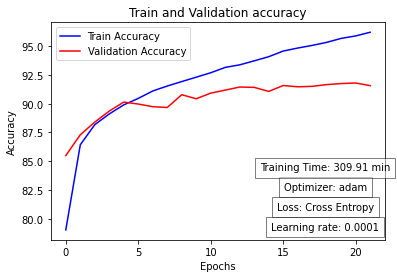

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Time elapsed:  309.9140598376592  minutes


In [8]:

begin_time = time.time()
training(train_loader,model, learning_rate, num_epochs, patience_for_early_stopping = patience_value,start_time = begin_time, loss_function = loss_function_param ,
         optimizer_choice = optimizer_choice_param, validation = validation_status, validation_loader = val_loader, 
         name_run_wandb = wandb_run_name,wandb_log_status=flag_wandb_log_status, plots = True)
end_time = time.time()
print("Time elapsed: ",(end_time-begin_time)/60," minutes")
model_train_iteration += 1 
# Save the model and plot
model_save_name = "Trained_model" +"_lr:"+str(learning_rate)+"_epochs:"+str(num_epochs) +"_"+ str(model_train_iteration)
torch.save(model.state_dict(), path_model_final_save + model_save_name)



cuda
Accuracy:  90.69


Train Accuracy,96.212
Train Loss,0.10734
_step,44
_runtime,18598
_timestamp,1604057452
Valid Accuracy,91.57
Valid Loss,0.25697
Test Accuracy,90.69


Train Accuracy,▁▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇█████
Train Loss,█▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
Valid Accuracy,▁▃▄▅▆▆▆▆▇▆▇▇██▇███████
Valid Loss,█▅▄▃▃▂▃▃▂▂▂▁▁▁▂▁▁▁▁▁▂▂
Test Accuracy,▁


 
[[829   1  10  11   4   1 133   0  11   0]
 [  1 991   0   4   0   0   3   0   1   0]
 [ 22   1 816   8  49   0 103   0   1   0]
 [ 12  10   7 889  38   0  36   0   8   0]
 [  2   1  61  15 854   0  64   0   3   0]
 [  0   0   0   0   0 986   0   9   0   5]
 [ 90   4  30  17  66   0 781   0  12   0]
 [  0   0   0   0   0  11   0 973   1  15]
 [  2   1   1   1   1   1   3   1 989   0]
 [  0   0   0   0   0   7   1  30   1 961]]
 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

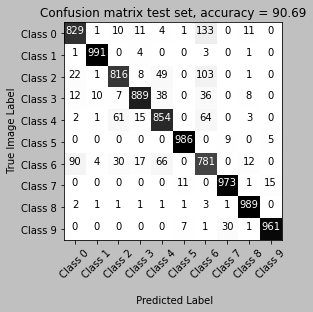

              precision    recall  f1-score   support

           0       0.87      0.83      0.85      1000
           1       0.98      0.99      0.99      1000
           2       0.88      0.82      0.85      1000
           3       0.94      0.89      0.91      1000
           4       0.84      0.85      0.85      1000
           5       0.98      0.99      0.98      1000
           6       0.69      0.78      0.74      1000
           7       0.96      0.97      0.97      1000
           8       0.96      0.99      0.98      1000
           9       0.98      0.96      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



In [9]:
# Testing cell
# Confusion matrix plot and some other metrics like recall, precision and accuracy.
flag_wandb_log_status = True
b_s = test_loader.batch_size
length_loader = len(test_loader)
prediction_dataset, correct_label, test_accuracy = prediction(test_loader, model, wandb_log_status = flag_wandb_log_status )
if(flag_wandb_log_status == True):
  run_object.finish()


length_prediction = b_s*length_loader
prediction_dataset = np.array(prediction_dataset)
prediction_dataset.resize([1,length_prediction])
prediction_dataset.squeeze()
prediction_dataset = prediction_dataset.tolist()
prediction_dataset = prediction_dataset[0]


correct_label = np.array(correct_label)
correct_label.resize([1,length_prediction])
correct_label.squeeze()
correct_label = correct_label.tolist()
correct_label = correct_label[0]

c_matrix = (confusion_matrix(correct_label, prediction_dataset,labels= [0,1,2,3,4,5,6,7,8,9]))

CM_title = "Confusion matrix test set, accuracy = " + str(test_accuracy)

print(" ")
print(c_matrix)
print(" ")
classes = ["Class 0","Class 1","Class 2","Class 3","Class 4","Class 5","Class 6","Class 7","Class 8","Class 9"]
confusion_matrix_plot(c_matrix, classes , title= CM_title, name_run_wandb = wandb_run_name)
print(classification_report(correct_label, prediction_dataset))